In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

import os
from numba import njit
import sys 
module_path = "src"
sys.path.append(module_path)
import polyomino_gcmc_simulation






In [43]:
omino_1 = np.array([[0,0],[0,1],[0,2]],dtype=np.int32)
omino_2 = np.array([[0,0],[0,1],[1,0]],dtype=np.int32)


omino_1 = omino_1[..., np.newaxis]  
omino_2 = omino_2[..., np.newaxis] 


ominos_sizes= np.array([3,3],dtype=np.int32)
max_omino_size=np.max(ominos_sizes)

omino_shapes = np.concatenate([omino_1, omino_2], axis=2)
n_omino_types = omino_shapes.shape[-1]





In [44]:
box_size = 40
initial_n_ominos_per_shape=np.array([1,1],dtype=np.int32)
initial_n_ominos = np.sum(initial_n_ominos_per_shape)

crystal_cell_size_x = 2
crystal_cell_size_y = max_omino_size
crystal_n_cells = (box_size//crystal_cell_size_x)*(box_size//crystal_cell_size_y)

if crystal_n_cells < initial_n_ominos:
    raise ValueError('INCREASE box_size')


crystal_coords=[]
for ix in range(box_size//crystal_cell_size_x):
    for iy in range(box_size//crystal_cell_size_y):
        crystal_coords.append([ix*crystal_cell_size_x+1,iy*crystal_cell_size_y+1])
crystal_coords=np.array(crystal_coords,dtype=np.int32)

crystal_coords_order=np.arange(crystal_n_cells,dtype=np.int32)
np.random.shuffle(crystal_coords_order)
crystal_coords_order=crystal_coords_order[:initial_n_ominos]

initial_positions=crystal_coords[crystal_coords_order]
initial_orientations = np.ones(initial_n_ominos,dtype=np.int32)


In [45]:
n_savings=1000

n_mc_steps=30000*n_savings

save_every=n_mc_steps//n_savings
prng_seed=np.random.randint(1,100000)

max_n_ominos=5000
move_probabilities=np.array([0.0,0.0,0.5,0.5])

mu_1=3.0
mu_2_to_do=np.linspace(0.0,10.0,21)

all_results=[]

for i_mu_2 in range(len(mu_2_to_do)):


    chemical_potentials=np.array([mu_1,mu_2_to_do[i_mu_2]])

    start_time = time.time()
    system_snapshots,history_positions,history_orientations,history_n_ominos,\
        history_n_ominos_per_shape,history_vec_omino_types = polyomino_gcmc_simulation.polyomino_gcmc_simulation(
        n_mc_steps=n_mc_steps,
        n_savings=n_savings,
        n_omino_types=n_omino_types,
        ominos_sizes=ominos_sizes,
        max_omino_size=max_omino_size,
        omino_shapes=omino_shapes,
        initial_n_ominos_per_shape=initial_n_ominos_per_shape, 
        initial_n_ominos=initial_n_ominos,
        initial_positions=initial_positions,
        initial_orientations=initial_orientations,
        max_n_ominos=max_n_ominos,
        chemical_potentials=chemical_potentials,
        move_probabilities=move_probabilities,
        box_size=box_size,
        prng_seed=prng_seed
    )
    all_results.append(
        {   
            'chemical_potentials':chemical_potentials,
            'system_snapshots':system_snapshots,
            'history_positions':history_positions,
            'history_orientations':history_orientations,
            'history_n_ominos':history_n_ominos,
            'history_n_ominos_per_shape':history_n_ominos_per_shape,
            'history_vec_omino_types':history_vec_omino_types,
        }
    )

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 1.74 seconds
Execution time: 1.81 seconds
Execution time: 1.92 seconds
Execution time: 2.02 seconds
Execution time: 2.20 seconds
Execution time: 2.37 seconds
Execution time: 2.79 seconds
Execution time: 3.26 seconds
Execution time: 3.95 seconds
Execution time: 4.65 seconds
Execution time: 5.57 seconds
Execution time: 6.53 seconds
Execution time: 7.31 seconds
Execution time: 8.03 seconds
Execution time: 8.64 seconds
Execution time: 8.89 seconds
Execution time: 8.92 seconds
Execution time: 8.70 seconds
Execution time: 8.51 seconds
Execution time: 8.22 seconds
Execution time: 7.95 seconds


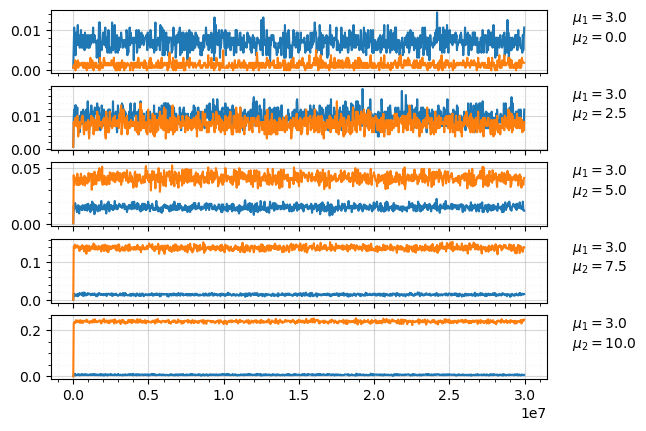

In [46]:
ind_to_plot_trajectories=[0,5,10,15,len(all_results)-1]

fig,axs=plt.subplots(nrows=len(ind_to_plot_trajectories),sharex=True)
x_to_plot_trajectory=np.arange(n_savings)*save_every
for ax in axs.flatten():
    ax.grid(alpha=0.5, which='both')
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
    ax.minorticks_on()
    ax.set_axisbelow(True)


for i_ax, ind in enumerate(ind_to_plot_trajectories):
    ax=axs.flatten()[i_ax]
    ax.plot(x_to_plot_trajectory,all_results[ind]['history_n_ominos_per_shape'][0,:]/box_size**2)
    ax.plot(x_to_plot_trajectory,all_results[ind]['history_n_ominos_per_shape'][1,:]/box_size**2)
    ax.text(1.05,0.5,f"$\mu_1={all_results[ind]['chemical_potentials'][0]:}$\
\n$\mu_2={all_results[ind]['chemical_potentials'][1]:}$",transform=ax.transAxes)

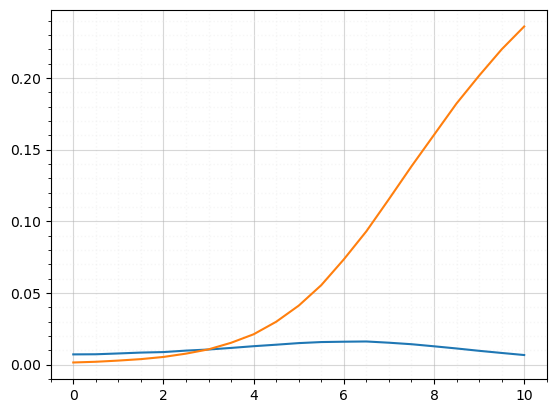

In [48]:
fig,ax=plt.subplots()
ax.grid(alpha=0.5, which='both')
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
ax.minorticks_on()
ax.set_axisbelow(True)

n_equilibration=500
all_ave_n_ominos_per_shape=[]
for i_mu_2 in range(len(mu_2_to_do)):
    all_ave_n_ominos_per_shape.append(
        all_results[i_mu_2]['history_n_ominos_per_shape'][:,n_equilibration:].mean(axis=1)
    )

all_ave_n_ominos_per_shape=np.array(all_ave_n_ominos_per_shape)
ax.plot(mu_2_to_do,all_ave_n_ominos_per_shape[:,0]/box_size**2)
ax.plot(mu_2_to_do,all_ave_n_ominos_per_shape[:,1]/box_size**2)
